## ANÁLISIS DE DATOS EXTREMOS (OUTLIERS) Y PCA (PRINCIPAL COMPONENT ANALYSIS)

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.covariance import EllipticEnvelope, EmpiricalCovariance, MinCovDet
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import anderson
import seaborn as sns

# Cargar el dataset ajustado
df = pd.read_csv('https://raw.githubusercontent.com/ringoquimico/Portfolio/refs/heads/main/Data%20Sources/call_center_data.csv', sep=';', quotechar='"')

# Codificar variables categóricas
categorical_vars = ['channel', 'classification', 'resolved_in_sla', 'first_touch_resolution', 'csat_rated_group_name', 'issue_classification']
df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=False)
# Verificar columnas generadas
print("Columnas después de get_dummies:", df_encoded.columns.tolist())


Columnas después de get_dummies: ['case_id', 'date', 'start_of_week', 'start_of_month', 'translated_comments', 'sentiment', 'sentiment_rate', 'resolution_time_min', 'aht', 'talk_time', 'hold_time', 'wrap_up_time', 'csat_rating_received', 'group_name_history', 'groups', 'total_groups', 'channel_chatbot', 'channel_email', 'channel_phone', 'classification_DETRACTOR', 'classification_PROMOTER', 'resolved_in_sla_0', 'resolved_in_sla_1', 'first_touch_resolution_0', 'first_touch_resolution_1', 'csat_rated_group_name_Grupo A', 'csat_rated_group_name_Grupo B', 'csat_rated_group_name_Grupo C', 'csat_rated_group_name_Grupo D', 'csat_rated_group_name_Grupo E', 'csat_rated_group_name_Grupo F', 'csat_rated_group_name_Grupo G', 'csat_rated_group_name_Grupo H', 'csat_rated_group_name_Grupo I', 'csat_rated_group_name_Grupo J', 'issue_classification_Account Setup', 'issue_classification_Balance Inquiry', 'issue_classification_Card Issues', 'issue_classification_Fees Inquiry', 'issue_classification_Fraud

### OUTLIERS Y PCA

Número de muestras después de eliminar NaN: 15000
Número esperado de outliers (10% de contaminación): 1500

Prueba de normalidad (Anderson-Darling) por variable:
resolution_time_min: statistic = 3716.0630, critical value (5%) = 0.7870, Gaussian = False
csat_rating_received: statistic = 1092.4691, critical value (5%) = 0.7870, Gaussian = False
total_groups: statistic = 1326.1696, critical value (5%) = 0.7870, Gaussian = False
aht: statistic = 1559.8149, critical value (5%) = 0.7870, Gaussian = False
talk_time: statistic = 910.6164, critical value (5%) = 0.7870, Gaussian = False
hold_time: statistic = 731.1405, critical value (5%) = 0.7870, Gaussian = False
wrap_up_time: statistic = 820.5032, critical value (5%) = 0.7870, Gaussian = False
channel_chatbot: statistic = 3097.8282, critical value (5%) = 0.7870, Gaussian = False
channel_email: statistic = 3098.1512, critical value (5%) = 0.7870, Gaussian = False
channel_phone: statistic = 3092.6772, critical value (5%) = 0.7870, Gaussian = Fa

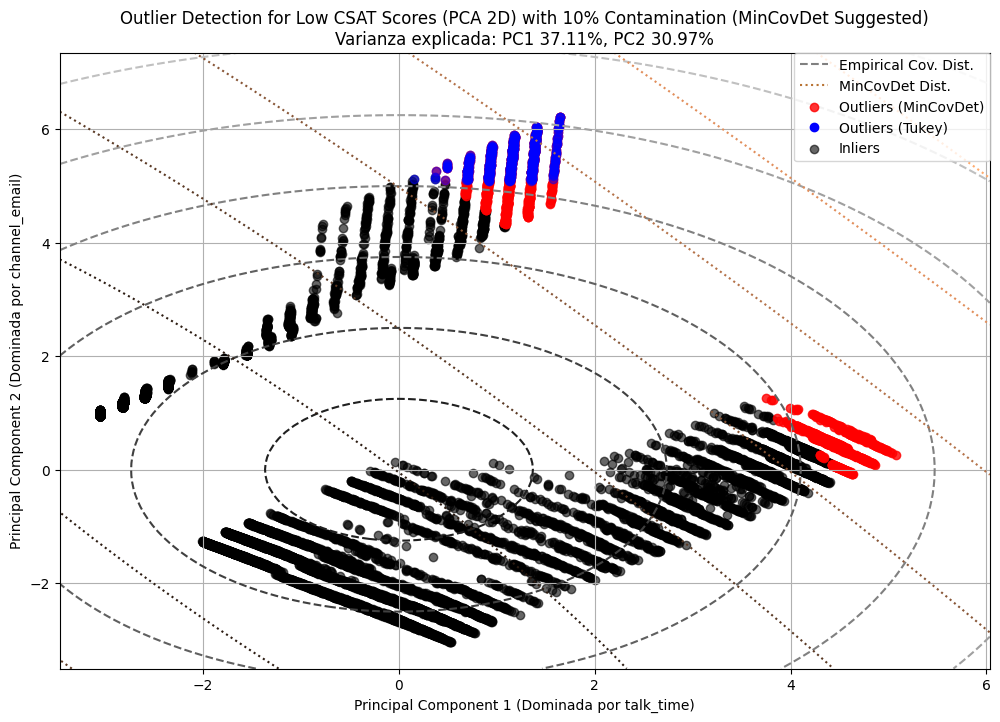

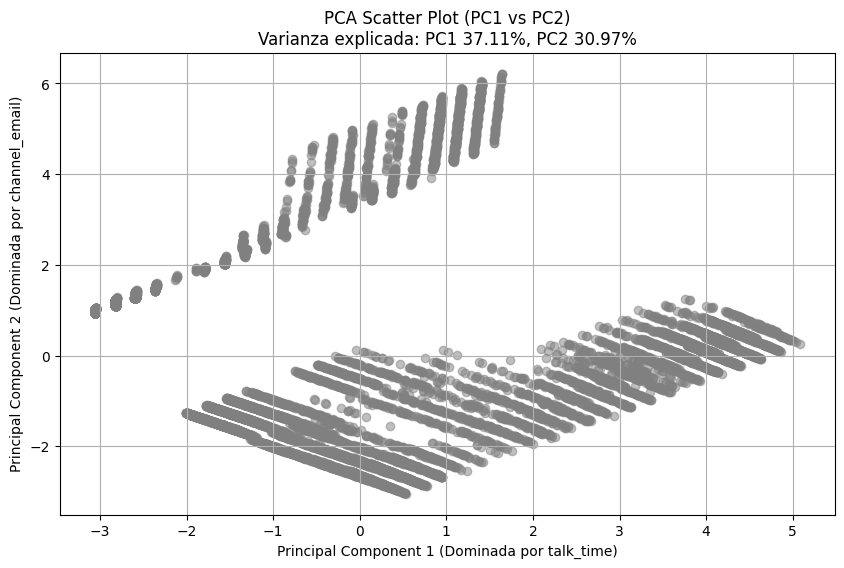

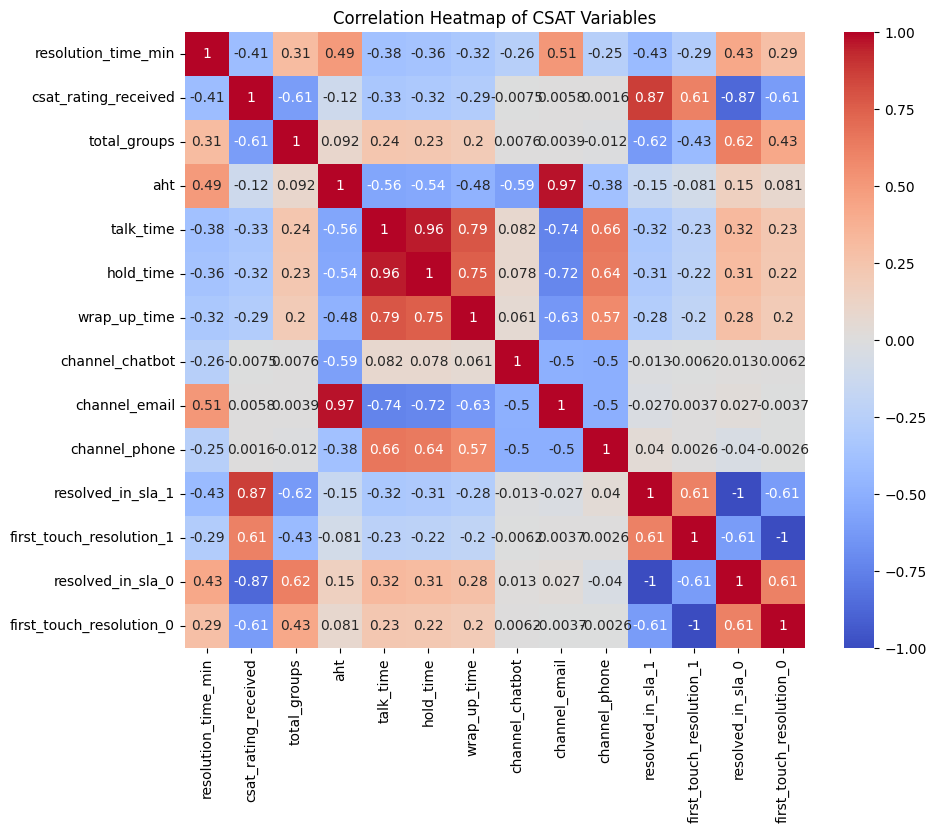


Número de outliers detectados por MinCovDet (10% contaminación): 1500
Porcentaje real de outliers (MinCovDet): 10.00%
Número de outliers detectados por Tukey: 500
Porcentaje real de outliers (Tukey): 3.33%

Primeras filas de df_outliers:
      case_id        date start_of_week start_of_month  \
0  CASE-15894  2022-02-05    2022-01-30     2022-02-01   
1  CASE-23493  2024-08-19    2024-08-18     2024-08-01   
2  CASE-27867  2024-09-06    2024-09-01     2024-09-01   

                                 translated_comments sentiment  \
0  The phone couldn’t handle my card issue, I’m i...  negative   
1  The phone couldn’t handle my login problem com...  negative   
2  The chatbot was rude, they failed to resolve m...  negative   

   sentiment_rate  resolution_time_min   aht  talk_time  ...  \
0               1                39.94  15.0      11.56  ...   
1               2                88.22  15.0       9.16  ...   
2               2                36.77  15.0      10.37  ...   

   iss

In [79]:


# Definir variables para el análisis de outliers
df_clean = df_encoded.copy()
id_columns = ['case_id']
var_list = [
    'resolution_time_min', 'csat_rating_received', 'total_groups',
    'aht', 'talk_time', 'hold_time', 'wrap_up_time',
    'channel_chatbot', 'channel_email', 'channel_phone', 'resolved_in_sla_1', 'first_touch_resolution_1', 'resolved_in_sla_0', 'first_touch_resolution_0'
]
all_list = id_columns + var_list

# Seleccionar datos y eliminar NaN
df_clean = df_clean.dropna(subset=all_list)
X = df_clean[var_list].values

# Verificar el número real de muestras después de eliminar NaN
print(f"Número de muestras después de eliminar NaN: {X.shape[0]}")
n_samples = X.shape[0]
n_outliers_expected = int(n_samples * 0.1)  # 10% de contaminación
print(f"Número esperado de outliers (10% de contaminación): {n_outliers_expected}")

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verificar normalidad con la prueba de Anderson-Darling
print("\nPrueba de normalidad (Anderson-Darling) por variable:")
is_gaussian = []
for i, var in enumerate(var_list):
    result = anderson(X_scaled[:, i])
    is_gaussian_var = result.statistic < result.critical_values[2]  # Nivel de significancia del 5%
    is_gaussian.append(is_gaussian_var)
    print(f"{var}: statistic = {result.statistic:.4f}, critical value (5%) = {result.critical_values[2]:.4f}, Gaussian = {is_gaussian_var}")

# Decisión lógica: si más del 50% de las variables no son gaussianas, usar MinCovDet
gaussian_count = sum(is_gaussian)
total_vars = len(var_list)
print(f"\nPorcentaje de variables gaussianas: {(gaussian_count / total_vars) * 100:.1f}%")
method = "MinCovDet" if (gaussian_count / total_vars) < 0.5 else "EllipticEnvelope"
print(f"Método sugerido: {method} (basado en que más del 50% de las variables sean gaussianas)")

# Reducir a 2 dimensiones para visualización usando PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Identificar PC1 y PC2 (loadings de las variables originales)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
print("\nContribuciones de las variables a las Componentes Principales (loadings):")
for i, var in enumerate(var_list):
    print(f"{var}: PC1 = {loadings[i, 0]:.4f}, PC2 = {loadings[i, 1]:.4f}")
print(f"Porcentaje de varianza explicada: PC1 = {pca.explained_variance_ratio_[0] * 100:.2f}%, PC2 = {pca.explained_variance_ratio_[1] * 100:.2f}%")

# Interpretación básica
pc1_dominant = var_list[np.argmax(np.abs(loadings[:, 0]))]
pc2_dominant = var_list[np.argmax(np.abs(loadings[:, 1]))]
print(f"\nPC1 está dominada principalmente por: {pc1_dominant}")
print(f"PC2 está dominada principalmente por: {pc2_dominant}")

# Ajustar el modelo para el método sugerido
if method == "EllipticEnvelope":
    model = EllipticEnvelope(contamination=0.1, random_state=42).fit(X_2d)
    predictions = model.predict(X_2d)
    outlier_indices = np.where(predictions == -1)[0]
    mahal_robust = model.mahalanobis(X_2d)
    threshold = np.mean(mahal_robust) + np.std(mahal_robust)  # Umbral aproximado
else:  # MinCovDet
    model = MinCovDet(random_state=42).fit(X_2d)
    mahal_distances = model.mahalanobis(X_2d)
    threshold = np.percentile(mahal_distances, 100 * (1 - 0.1))  # Umbral para el 10% de outliers
    outlier_indices = np.where(mahal_distances > threshold)[0]
    mahal_robust = mahal_distances

# Ajustar Tukey en las componentes principales
q1_x = np.percentile(X_2d[:, 0], 25)
q3_x = np.percentile(X_2d[:, 0], 75)
iqr_x = q3_x - q1_x
lower_bound_x = q1_x - 1.5 * iqr_x
upper_bound_x = q3_x + 1.5 * iqr_x

q1_y = np.percentile(X_2d[:, 1], 25)
q3_y = np.percentile(X_2d[:, 1], 75)
iqr_y = q3_y - q1_y
lower_bound_y = q1_y - 1.5 * iqr_y
upper_bound_y = q3_y + 1.5 * iqr_y

# Imprimir los límites para depuración
print("\nLímites de Tukey para la Componente Principal 1 (PC1):")
print(f"Límite inferior: {lower_bound_x:.2f}")
print(f"Límite superior: {upper_bound_x:.2f}")
print("\nLímites de Tukey para la Componente Principal 2 (PC2):")
print(f"Límite inferior: {lower_bound_y:.2f}")
print(f"Límite superior: {upper_bound_y:.2f}")

# Identificar outliers de Tukey
tukey_outliers_x = (X_2d[:, 0] < lower_bound_x) | (X_2d[:, 0] > upper_bound_x)
tukey_outliers_y = (X_2d[:, 1] < lower_bound_y) | (X_2d[:, 1] > upper_bound_y)
tukey_outlier_indices = np.where(tukey_outliers_x | tukey_outliers_y)[0]

# Determinar el tipo de outlier para Tukey
outlier_types_tukey = []
for idx in tukey_outlier_indices:
    x_val = X_2d[idx, 0]
    y_val = X_2d[idx, 1]
    if x_val > upper_bound_x or y_val > upper_bound_y:
        outlier_types_tukey.append("Superior")
    elif x_val < lower_bound_x or y_val < lower_bound_y:
        outlier_types_tukey.append("Inferior")
    else:
        outlier_types_tukey.append("Unknown")

# Contar outliers superiores e inferiores para Tukey
tukey_superior_count = sum(1 for t in outlier_types_tukey if t == "Superior")
tukey_inferior_count = sum(1 for t in outlier_types_tukey if t == "Inferior")
print(f"\nOutliers detectados por Tukey:")
print(f"Superiores: {tukey_superior_count}")
print(f"Inferiores: {tukey_inferior_count}")

# Reset index to ensure alignment
df_clean = df_clean.reset_index(drop=True)

# Create key by concatenating id_columns
df_clean['Key'] = df_clean[id_columns].astype(str).agg('-'.join, axis=1)

# Determine outlier type for the suggested method
outlier_types_method = []
for idx in outlier_indices:
    mahal_value = mahal_robust[idx]
    if mahal_value > threshold:
        outlier_types_method.append("Superior")
    else:
        outlier_types_method.append("Inferior")

# Create df_outliers for the suggested method
df_outliers = df_clean.iloc[outlier_indices].copy()
df_outliers['Tipo_Outlier'] = outlier_types_method
df_outliers['Metodo_Seleccionado'] = method
df_outliers = df_outliers.reset_index(drop=True)

# Create df_outliers_tukey for Tukey method
df_outliers_tukey = df_clean.iloc[tukey_outlier_indices].copy()
df_outliers_tukey['Tipo_Outlier'] = outlier_types_tukey
df_outliers_tukey['Metodo_Seleccionado'] = "Tukey"
df_outliers_tukey = df_outliers_tukey.reset_index(drop=True)

# Comparar con un estimador empírico (no robusto)
emp_cov = EmpiricalCovariance().fit(X_2d)

# Visualización de la gráfica con envolventes
plt.figure(figsize=(12, 8))
subfig1 = plt.gca()

# Graficar inliers, outliers del método sugerido y outliers de Tukey
inliers = X_2d[mahal_distances <= threshold] if method == "MinCovDet" else X_2d[predictions == 1]
outliers_method = X_2d[outlier_indices]
outliers_tukey = X_2d[tukey_outlier_indices]
inlier_plot = subfig1.scatter(inliers[:, 0], inliers[:, 1], color='black', label='Inliers', alpha=0.6)
outlier_plot_method = subfig1.scatter(outliers_method[:, 0], outliers_method[:, 1], color='red', label=f'Outliers ({method})', alpha=0.8)
outlier_plot_tukey = subfig1.scatter(outliers_tukey[:, 0], outliers_tukey[:, 1], color='blue', label='Outliers (Tukey)', alpha=0.5)

# Ajustar límites del gráfico
subfig1.set_xlim(subfig1.get_xlim()[0], subfig1.get_xlim()[1] * 1.1)
subfig1.set_ylim(subfig1.get_ylim()[0], subfig1.get_ylim()[1] * 1.1)
subfig1.set_title(f"Outlier Detection for Low CSAT Scores (PCA 2D) with 10% Contamination ({method} Suggested)\nVarianza explicada: PC1 {pca.explained_variance_ratio_[0]*100:.2f}%, PC2 {pca.explained_variance_ratio_[1]*100:.2f}%")

# Crear una malla para los contornos
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

# Contorno empírico
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = subfig1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.gray,
                                  linestyles='dashed')

# Contorno robusto
mahal_robust_contour = model.mahalanobis(zz)
mahal_robust_contour = mahal_robust_contour.reshape(xx.shape)
robust_contour = subfig1.contour(xx, yy, np.sqrt(mahal_robust_contour),
                                 cmap=plt.cm.copper, linestyles='dotted')

# Crear proxy artists para la leyenda
empirical_proxy = Line2D([0], [0], color='gray', linestyle='dashed', label='Empirical Cov. Dist.')
robust_proxy = Line2D([0], [0], color='#B87333', linestyle='dotted', label=f'{method} Dist.')
tukey_proxy = Line2D([0], [0], color='blue', marker='o', linestyle='none', label='Tukey Outliers')

# Añadir leyenda
subfig1.legend([empirical_proxy, robust_proxy, outlier_plot_method, tukey_proxy, inlier_plot],
               ['Empirical Cov. Dist.', f'{method} Dist.', f'Outliers ({method})', 'Outliers (Tukey)', 'Inliers'],
               loc="upper right", borderaxespad=0)

# Etiquetas de los ejes actualizadas con identificación de PC
plt.xlabel(f'Principal Component 1 (Dominada por {pc1_dominant})')
plt.ylabel(f'Principal Component 2 (Dominada por {pc2_dominant})')

# Mostrar la gráfica de envolvente
plt.grid(True)
plt.show()

# Nueva gráfica separada de PCA (scatter plot simple)
plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.5, color='gray')
plt.title(f'PCA Scatter Plot (PC1 vs PC2)\nVarianza explicada: PC1 {pca.explained_variance_ratio_[0]*100:.2f}%, PC2 {pca.explained_variance_ratio_[1]*100:.2f}%')
plt.xlabel(f'Principal Component 1 (Dominada por {pc1_dominant})')
plt.ylabel(f'Principal Component 2 (Dominada por {pc2_dominant})')
plt.grid(True)
plt.show()

# Heatmap de correlaciones
plt.figure(figsize=(10, 8))
correlation_matrix = df_clean[var_list].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of CSAT Variables')
plt.show()

# Imprimir información adicional
print(f"\nNúmero de outliers detectados por {method} (10% contaminación): {len(outlier_indices)}")
print(f"Porcentaje real de outliers ({method}): {(len(outlier_indices) / n_samples) * 100:.2f}%")
print(f"Número de outliers detectados por Tukey: {len(tukey_outlier_indices)}")
print(f"Porcentaje real de outliers (Tukey): {(len(tukey_outlier_indices) / n_samples) * 100:.2f}%")
print("\nPrimeras filas de df_outliers:")
print(df_outliers.head(3))
print("\nPrimeras filas de df_outliers_tukey:")
print(df_outliers_tukey.head(3))

# Exportar resultados
df_outliers.to_csv('csat_outliers_adjusted.csv', index=False)
df_outliers_tukey.to_csv('csat_outliers_tukey_adjusted.csv', index=False)
print("\nArchivos 'csat_outliers_adjusted.csv' y 'csat_outliers_tukey_adjusted.csv' creados.")

### ANÁLISIS DE RESULTADOS

In [83]:

# Paso 1: Validar causas de CSAT scores bajos
print("\n=== Paso 1: Validar causas de CSAT scores bajos ===")
low_csat_outliers = df_outliers[df_outliers['csat_rating_received'] < 3]
print("\nOutliers con CSAT scores bajos (< 3):")
print(low_csat_outliers[['Key', 'csat_rating_received', 'channel_email','channel_phone','channel_chatbot', 'resolution_time_min', 'total_groups', 'aht', 'resolved_in_sla_1', 'resolved_in_sla_0']].head(5))

correlation_with_csat = df_clean[var_list].corr()['csat_rating_received'].sort_values(ascending=False)
print("\nCorrelación de csat_rating_received con otras variables:")
print(correlation_with_csat)

# Identificar la causa de CSAT bajos: variable con correlación negativa más fuerte
negative_correlations = correlation_with_csat[correlation_with_csat < 0].sort_values()
if not negative_correlations.empty:
    main_cause = negative_correlations.index[0]  # Variable con correlación negativa más fuerte
    secondary_cause = negative_correlations.index[1] if len(negative_correlations) > 1 else None  # Segunda correlación negativa
else:
    main_cause = correlation_with_csat.index[1]  # Fallback a la segunda más correlacionada si no hay negativas
    secondary_cause = None

print(f"\nVariable más asociada con CSAT scores bajos (basada en correlación negativa): {main_cause}")
if secondary_cause:
    print(f"Variable secundaria más asociada con CSAT scores bajos: {secondary_cause}")

# Paso 2: Investigar causas secundarias con más componentes
print("\n=== Paso 2: Investigar causas secundarias con más componentes ===")
pca_extended = PCA(n_components=0.8)
X_pca = pca_extended.fit_transform(X_scaled)
print(f"Número de componentes para el 80% de varianza: {pca_extended.n_components_}")
print(f"Varianza total explicada: {sum(pca_extended.explained_variance_ratio_)*100:.2f}%")

loadings_pc3 = pca_extended.components_[2]
print("\nLoadings de PC3:")
for i, var in enumerate(var_list):
    print(f"{var}: {loadings_pc3[i]:.4f}")
pc3_dominant = var_list[np.argmax(np.abs(loadings_pc3))]
print(f"PC3 está dominada principalmente por: {pc3_dominant}")

# Relajar aún más el umbral para detectar outliers en PC3
q1_pc3 = np.percentile(X_pca[:, 2], 25)
q3_pc3 = np.percentile(X_pca[:, 2], 75)
iqr_pc3 = q3_pc3 - q1_pc3
lower_bound_pc3 = q1_pc3 - 3.0 * iqr_pc3  # Ajustado a 3.0*IQR
upper_bound_pc3 = q3_pc3 + 3.0 * iqr_pc3
outliers_pc3 = (X_pca[:, 2] < lower_bound_pc3) | (X_pca[:, 2] > upper_bound_pc3)
outliers_pc3_indices = np.where(outliers_pc3)[0]
print(f"\nNúmero de outliers en PC3 (con umbral 3.0*IQR): {len(outliers_pc3_indices)}")

df_outliers_pc3 = df_clean.iloc[outliers_pc3_indices].copy()
df_outliers_pc3['Tipo_Outlier'] = np.where(X_pca[outliers_pc3_indices, 2] > upper_bound_pc3, 'Superior', 'Inferior')
print("\nOutliers en PC3 (primeras filas):")
print(df_outliers_pc3[['Key', pc3_dominant, 'csat_rating_received', 'resolved_in_sla_1', 'resolved_in_sla_0']].head())

# Análisis adicional: revisar el impacto de channel_chatbot directamente
chatbot_cases = df_clean[df_clean['channel_chatbot'] == 1]
avg_csat_chatbot = chatbot_cases['csat_rating_received'].mean()
print(f"\nCSAT promedio en casos manejados por channel_chatbot: {avg_csat_chatbot:.2f}")

# Paso 3: Segmentar outliers por PC2
print("\n=== Paso 3: Segmentar outliers por PC2 ===")
pc2_threshold_high = np.percentile(X_2d[:, 1], 75)
pc2_threshold_low = np.percentile(X_2d[:, 1], 25)

high_impact = df_outliers[X_2d[outlier_indices, 1] > pc2_threshold_high]
low_impact = df_outliers[X_2d[outlier_indices, 1] < pc2_threshold_low]

print("\nOutliers con alta influencia de PC2 (posiblemente canales problemáticos):")
print(high_impact[['Key', 'csat_rating_received', pc2_dominant, 'resolved_in_sla_1', 'resolved_in_sla_0']].head())
print("\nOutliers con baja influencia de PC2:")
print(low_impact[['Key', 'csat_rating_received', pc2_dominant, 'resolved_in_sla_1', 'resolved_in_sla_0']].head())

avg_csat_high = high_impact['csat_rating_received'].mean()
avg_csat_low = low_impact['csat_rating_received'].mean() if not low_impact.empty else float('nan')
print(f"\nCSAT promedio en casos de alta influencia (PC2): {avg_csat_high:.2f}")
print(f"CSAT promedio en casos de baja influencia (PC2): {avg_csat_low:.2f}")

# Paso 4: Estrategias para mejorar CSAT
print("\n=== Paso 4: Estrategias para mejorar CSAT scores ===")
print("Conclusión basada en datos:")
print(f"- La variable más asociada con CSAT scores bajos es: {main_cause}.")
print(f"- La variable secundaria más asociada con CSAT scores bajos es: {secondary_cause}.")
print(f"- PC3, dominada por {pc3_dominant}, sugiere posibles diferencias entre canales, pero no se detectaron outliers extremos.")
print(f"- Los casos con alta influencia de PC2 (dominada por {pc2_dominant}) tienen un CSAT promedio de {avg_csat_high:.2f}, lo que indica problemas específicos con este canal.")

print("\nRecomendaciones:")
print(f"1. Prioriza reducir {main_cause}: Mejora el cumplimiento del SLA para reducir los casos fuera del SLA.")
print(f"2. Aborda causas secundarias: Dado que {secondary_cause} indica que no resolver en el primer contacto afecta el CSAT, implementa estrategias para mejorar la resolución en el primer contacto.")
print(f"3. Enfócate en el canal problemático identificado por PC2: Dado que {pc2_dominant} está asociado con CSAT bajos (promedio {avg_csat_high:.2f}), mejora el soporte por email, especialmente en tiempos de resolución.")
print(f"4. Analiza el rendimiento del chatbot: Aunque no se detectaron outliers en PC3, el CSAT promedio en casos manejados por {pc3_dominant} es {avg_csat_chatbot:.2f}. Revisa su efectividad para resolver consultas.")
print("5. Monitorea casos con CSAT bajo: Usa los archivos CSV para seguimiento y analiza los datos numéricos para identificar patrones.")


=== Paso 1: Validar causas de CSAT scores bajos ===

Outliers con CSAT scores bajos (< 3):
          Key  csat_rating_received  channel_email  channel_phone  \
0  CASE-15894                     1              0              1   
1  CASE-23493                     1              0              1   
2  CASE-27867                     1              0              0   
3  CASE-26869                     1              0              1   
4  CASE-26502                     2              1              0   

   channel_chatbot  resolution_time_min  total_groups   aht  \
0                0                39.94             4  15.0   
1                0                88.22             3  15.0   
2                1                36.77             4  15.0   
3                0                51.89             4  15.0   
4                0              9367.15             3  45.0   

   resolved_in_sla_1  resolved_in_sla_0  
0                  0                  1  
1                  0          